# Solver configuration as a bandit problem

In this tutorial we are interested in minimizing the expected branch-and-bound tree size of the SCIP solver by tuning the parameter [`branching/scorefac`](https://www.scipopt.org/doc/html/PARAMETERS.php), which takes values in the range $[0,1]$. This parameter, used in combination with the sum score function (`branching/scorefunc = s`), controls the weighting of downward and upward gain predictions in the computation of branching scores. It has a default value of 0.167.

Required third-party libraries:
 - numpy
 - matplotlib
 - scikit-optimize
 
## 1. Setting up the Ecole environment

We formulate this parameter tuning task as a continuum-armed bandit problem, which we instantiate using a [`Configuring`](https://doc.ecole.ai/master/reference/environments.html#configuring) environment. We request no observation (non-contextual bandit), and use the negative number of nodes as a reward (tree size minimization).

In [1]:
import ecole as ec

env = ec.environment.Configuring(

    # set up a few SCIP parameters
    scip_params={
        "branching/scorefunc": 's',  # sum score function
        "branching/vanillafullstrong/priority": 666666,  # use vanillafullstrong (highest priority)
        "presolving/maxrounds": 0,  # deactivate presolving
    },

    # pure bandit, no observation
    observation_function=None,

    # minimize the total number of nodes
    reward_function=-ec.reward.NNodes(),

    # collect additional metrics for information
    information_function={
        'nnodes': ec.reward.NNodes().cumsum(),
        'lpiters': ec.reward.LpIterations().cumsum(),
        'time': ec.reward.SolvingTime().cumsum(),
    }
)

We set up SCIP to use the sum score function for branching (`branching/scorefunc=s`), and the *vanillafullstrong* branching rule to mitigate the impact of branching heuristics (`branching/vanillafullstrong/priority=666666`). For the purpose of the tutorial we also deactivate presolving (`presolving/maxrounds=0`) in order to reduce computational time.

## 2. Setting up the training distribution

For the purpose of this tutorial we will consider randomly generated Combinatorial Auction problems, as the problem distribution for which we want to configure the solver. We hence set up a `CombinatorialAuctionGenerator` that will generate such instances on the fly.

In [2]:
# infinite instance generator, new instances will be generated on-the-fly
instances = ec.instance.CombinatorialAuctionGenerator(
    n_items=100, n_bids=100, add_item_prob=0.7)

For training we consider small-sized instances ($100\times 100$), which are solved within seconds by SCIP but are difficult enough to produce tens of branc-and-bound nodes.

## 3. Solving the control problem

We can now readily solve the optimization problem using an off-the-shelf optimization library, such as `scikit-optimize`.

In [3]:
import skopt
import numpy as np

# change those values as desired
n_iters = 100
n_burnins = 10

# make the training process deterministic
seed = 42

env.seed(seed)  # environment (SCIP)
instances.seed(seed)  # instance generator
rng = np.random.RandomState(seed)  # optimizer

# set up the optimizer
opt = skopt.Optimizer(
    dimensions=[(0.0, 1.0)], base_estimator="GP", n_initial_points=n_burnins, random_state=rng,
    acq_func="PI", acq_optimizer="sampling", acq_optimizer_kwargs={'n_points': 10})

assert n_iters > n_burnins

# run the optimization
for i in range(n_iters):

    if (i+1) % 10 == 0:
        print(f"iteration {i+1} / {n_iters}")

    # pick up a new random instance
    instance = next(instances)

    # start a new episode
    env.reset(instance)

    # get the next action from the optimizer
    x = opt.ask()
    action = {"branching/scorefac": x[0]}

    # apply the action and collect the reward
    _, _, reward, _, _ = env.step(action)

    # update the optimizer
    opt.tell(x, -reward)  # minimize the negated reward (eq. maximize the reward)

iteration 10 / 100
iteration 20 / 100
iteration 30 / 100
iteration 40 / 100
iteration 50 / 100
iteration 60 / 100
iteration 70 / 100
iteration 80 / 100
iteration 90 / 100
iteration 100 / 100


We can now visualize of the result of the optimization process.

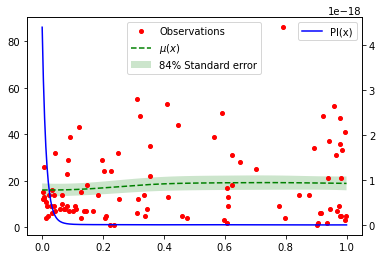

best parameter value: branching/scorefac = 0.028056112224448895


In [4]:
import matplotlib.pyplot as plt
import numpy as np

model = opt.models[-1]

x = np.linspace(0, 1, 500)
x_model = opt.space.transform(x.reshape(-1, 1).tolist())

fig, ax1 = plt.subplots()

# points sampled during optimization
ax1.plot(opt.Xi, opt.yi, "r.", markersize=8, label="Observations")

# value function estimation
y_mean, y_std = model.predict(x_model, return_std=True)
ax1.plot(x, y_mean, "g--", label=r"$\mu(x)$")
ax1.fill_between(x, y_mean - 1.6 * y_std, y_mean + 1.6 * y_std,
                 alpha=0.2, fc="g", ec="None", label="84% Standard error")
ax1.legend(loc='upper center')

# probability of improvement estimation
x_pi = skopt.acquisition.gaussian_pi(x_model, model, y_opt=np.min(opt.yi))
ax2 = ax1.twinx()
ax2.plot(x, x_pi, "b", label="PI(x)")
ax2.legend(loc='upper right')

plt.show()

# get best value based on a grid search on the value function estimator
best_value = x[np.argmin(y_mean)]
print(f"best parameter value: branching/scorefac = {best_value}")

## 4. Evaluation on harder instances

In [5]:
# we set up more challenging instances
test_instances = ec.instance.CombinatorialAuctionGenerator(
    n_items=150, n_bids=750, add_item_prob=0.7)

seed = 1337

for policy in ('default', 'learned'):

    print(f"evaluating policy '{policy}'")
    results = []

    for i in range(5):

        # evaluate each policy in the exact same settings
        env.seed(seed+i)  # environment (SCIP)
        test_instances.seed(seed+i)  # instance generator

        # pick up the next instance
        instance = next(test_instances)

        # set up the episode initial state
        env.reset(instance)

        # get the action from the policy
        if policy == 'default':
            action = {}  # will use the default value from SCIP
        else:
            action = {"branching/scorefac": best_value}

        # apply the action and collect the reward
        _, _, _, _, info = env.step(action)

        print(f"  instance {i+1}: {info['nnodes']} nodes, {info['lpiters']} lpiters, {info['time']} secs")

        results.append(info['nnodes'])

    print(f"  average performance: {np.mean(results)} nodes")

evaluating policy 'default'
  instance 1: 237.0 nodes, 31245.0 lpiters, 89.42058899999999 secs
  instance 2: 129.0 nodes, 20839.0 lpiters, 50.01423 secs
  instance 3: 85.0 nodes, 14522.0 lpiters, 27.978334 secs
  instance 4: 560.0 nodes, 61774.0 lpiters, 209.953958 secs
  instance 5: 107.0 nodes, 16027.0 lpiters, 32.659904 secs
  average performance: 223.6 nodes
evaluating policy 'learned'
  instance 1: 93.0 nodes, 16653.0 lpiters, 27.993955 secs
  instance 2: 68.0 nodes, 13572.0 lpiters, 23.425479 secs
  instance 3: 72.0 nodes, 13019.0 lpiters, 19.820258 secs
  instance 4: 135.0 nodes, 19150.0 lpiters, 46.229317 secs
  instance 5: 58.0 nodes, 9649.0 lpiters, 12.332561 secs
  average performance: 85.2 nodes
